In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision
import time
import copy

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'squeezenet1_1', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
# if operating on Collab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
for param in model.parameters():
  param.requires_grad = True

model.classifier._modules["1"] = nn.Conv2d(512, 7, kernel_size=(1, 1))

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

In [ ]:
# loading CK+ data from image folder
data_full = torchvision.datasets.ImageFolder(root='drive/My Drive/csc420_project/data', transform=preprocess)

# loading FER2013 data from image folder, change directory to your own
fer_train = torchvision.datasets.ImageFolder(root='drive/My Drive/csc420_project/fer2013/train', transform=preprocess)
fer_val = torchvision.datasets.ImageFolder(root='drive/My Drive/csc420_project/fer2013/val', transform=preprocess)
fer_test = torchvision.datasets.ImageFolder(root='drive/My Drive/csc420_project/fer2013/test', transform=preprocess)

In [ ]:
train_data, test_data = torch.utils.data.random_split(data_full, [800, len(data_full) - 800])

In [ ]:
data_full.classes

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

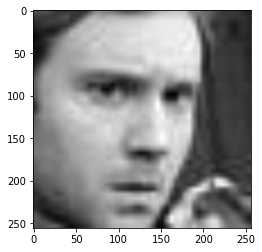

In [ ]:
def normalize(image):
  mean = image[0][0].mean()
  std = image[0][0].std()
  return (image - mean) / std

plt.imshow(normalize(fer_train[0][0])[0], cmap='gray')

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                         shuffle=False, num_workers=2)
trainloaderfer = torch.utils.data.DataLoader(fer_train, batch_size=100,
                                          shuffle=True, num_workers=2)
valloaderfer = torch.utils.data.DataLoader(fer_val, batch_size=100,
                                         shuffle=False, num_workers=2)
testloaderfer = torch.utils.data.DataLoader(fer_test, batch_size=100,
                                         shuffle=False, num_workers=2)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
# use GPU
use_cuda = torch.cuda.is_available()
print("training on CPU" if not use_cuda else "GPU in place!")
if use_cuda:
  device = torch.device("cuda")
  criterion = criterion.to(device)
  model = model.to(device)

training on CPU


In [ ]:
# train model
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    running_corrects = 0
    
    for i, data in enumerate(trainloaderfer, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if use_cuda:
          inputs = inputs.to(device)
          labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(normalize(inputs))
        if use_cuda:
          outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        if use_cuda:
          loss = loss.to(device)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        preds = outputs.argmax(axis=1)
        running_corrects += torch.sum(preds == labels)
        # if i%5 == 1:
        #   print('epoch', epoch, 'batch', i, 'acc:', running_corrects / ((i+1)*100),
        #         'loss:', running_loss / ((i+1)*100))


    epoch_loss = running_loss / len(fer_train)
    print('Epoch acc:', running_corrects / len(fer_train))
    print('Epoch average loss:', epoch_loss)
    if epoch%5 == 3:
      torch.save(model.state_dict(), 'drive/My Drive/csc420_project/squeezenet1_1_fer')

print('Finished Training')

KeyboardInterrupt: ignored

In [ ]:
total, correct = 0, 0
start = time.time()
for i, data in enumerate(testloaderfer, 0):
  inputs, labels = data
  normalized = normalize(inputs)
  outputs = model(normalized)
  total += len(outputs)
  correct += (outputs.argmax(axis=1)==labels).sum()
end = time.time()

In [ ]:
print('Average time taken:', (end-start) / len(testloaderfer) / 100, '\nAccuracy:', correct/total)

In [ ]:
# load pretrained model
model = torch.hub.load('pytorch/vision:v0.6.0', 'squeezenet1_1', pretrained=False)
for param in model.parameters():
  param.requires_grad = True

model.classifier._modules["1"] = nn.Conv2d(512, 7, kernel_size=(1, 1))
model.load_state_dict(torch.load('drive/My Drive/csc420_project/squeezenet1_1_97'))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


<All keys matched successfully>

In [ ]:
preprocess2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

# load from whereever Qinchen's photos are stored
my_face = torchvision.datasets.ImageFolder(root='drive/My Drive/csc420_project/test_data/', transform=preprocess2)

myfaceloader = torch.utils.data.DataLoader(my_face, batch_size=1,
                                         shuffle=False, num_workers=2)

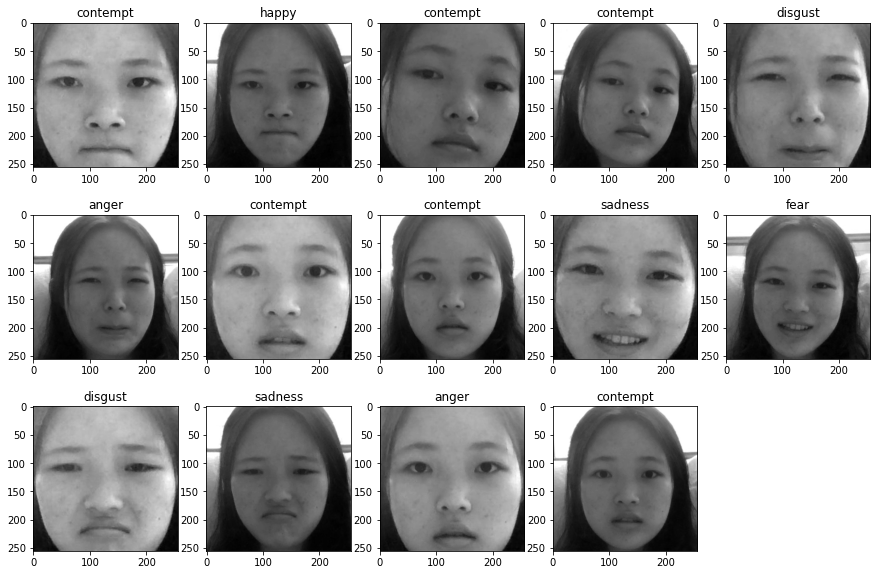

In [ ]:
plt.figure(figsize=(15, 10))
model.eval()

for i, data in enumerate(myfaceloader, 0):
  inputs, _ = data
  inputs[0][1] = inputs[0][0]
  inputs[0][2] = inputs[0][0]
  outputs = model(normalize(inputs))
  plt.subplot(3, 5, i+1)
  plt.imshow(inputs[0][0], cmap='gray')
  plt.title(data_full.classes[outputs.argmax(axis=1).item()])

plt.show()
  